In [18]:
# 1. Import necessary packages
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import find_parcellation_cut_coords
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [19]:
# Add  project root path
sys.path.append(os.path.abspath('..'))  # Adjust if needed
import config
from config.paths import *
print("Starting Phase 2: Graph Construction")

Starting Phase 2: Graph Construction


In [20]:

# 2. Load the processed metadata
metadata_path = os.path.join(PROCESSED_DIR, 'oasis_processed_metadata.csv')
df = pd.read_csv(metadata_path)
print(f"Loaded metadata for {len(df)} subjects")

Loaded metadata for 436 subjects


In [21]:
# 3. Load the AAL atlas
print("Loading AAL atlas...")
aal_atlas = datasets.fetch_atlas_aal()
atlas_filename = aal_atlas.maps
labels = aal_atlas.labels
print(f"AAL atlas loaded with {len(labels)} regions")


Loading AAL atlas...
[fetch_atlas_aal] Dataset found in C:\Users\rakes\nilearn_data\aal_SPM12
AAL atlas loaded with 117 regions


C:\Users\rakes\AppData\Local\Temp\ipykernel_22708\3265155633.py:3: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal_atlas = datasets.fetch_atlas_aal()


In [22]:
# 4. Create a masker to extract regional features
masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                          standardize=True,
                          memory='nilearn_cache',
                          verbose=1)

In [23]:

# 5. Get region coordinates for structural connectivity
print("Calculating region coordinates...")
coords = find_parcellation_cut_coords(atlas_filename)


Calculating region coordinates...


In [24]:
# 6. Create template structural connectivity matrix
print("Creating template connectivity matrix...")
dists = squareform(pdist(coords, 'euclidean'))
sigma = np.mean(dists)
adjacency_template = np.exp(-dists**2 / (2 * sigma**2))

# Threshold to create a sparse graph (keep top 15% of connections)
threshold = np.percentile(adjacency_template, 85)
adjacency_template[adjacency_template < threshold] = 0

# Convert to PyG format
edge_index = adjacency_template.nonzero()
edge_attr = adjacency_template[edge_index]
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr = torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1)

print(f"Created template with {edge_index.shape[1]} edges")

Creating template connectivity matrix...
Created template with 2020 edges


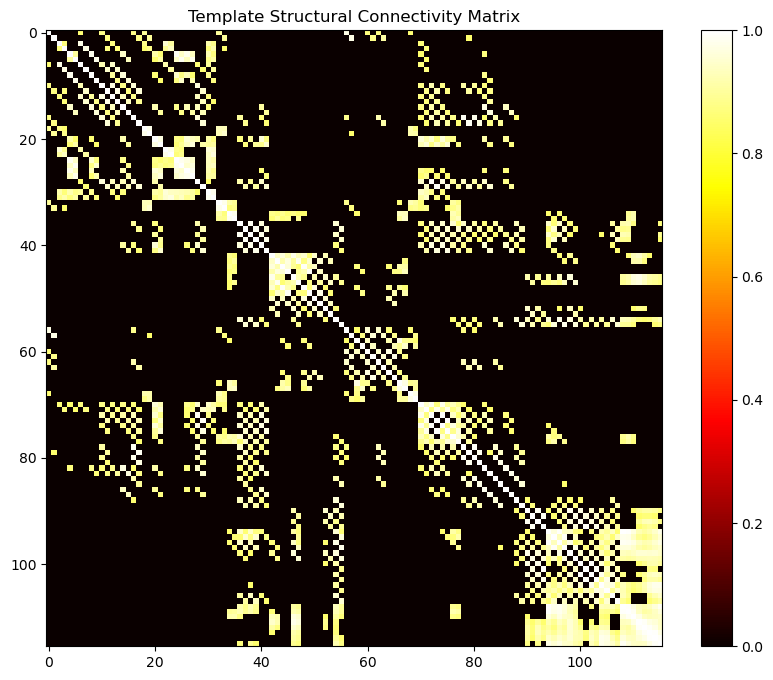

In [25]:
# 7. Visualize the template connectivity matrix
plt.figure(figsize=(10, 8))
plt.imshow(adjacency_template, cmap='hot', interpolation='nearest')
plt.title('Template Structural Connectivity Matrix')
plt.colorbar()
plt.savefig(os.path.join(RESULTS_DIR, 'template_connectivity_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Fixing the graph construction and analysis
print("\nGraph dataset analysis:")
print(f"Number of graphs: {len(graph_list)}")

if len(graph_list) > 0:
    print(f"Number of nodes per graph: {graph_list[0].num_nodes}")
    print(f"Number of edges per graph: {graph_list[0].num_edges}")
    
    # Check the shape of node features
    print(f"Node feature shape: {graph_list[0].x.shape}")
    
    # For 1D features, we don't have a second dimension
    if len(graph_list[0].x.shape) > 1:
        print(f"Node feature dimension: {graph_list[0].x.shape[1]}")
    else:
        print("Node features are 1-dimensional")
        
    # Count classes
    labels = [graph.y.item() for graph in graph_list]
    class_counts = pd.Series(labels).value_counts()
    print(f"\nClass distribution in graph dataset:")
    print(f"NonDemented (0): {class_counts.get(0, 0)}")
    print(f"Demented (1): {class_counts.get(1, 0)}")
else:
    print("No graphs were created. Please check the data processing steps.")


Graph dataset analysis:
Number of graphs: 416
Number of nodes per graph: 116
Number of edges per graph: 2020
Node feature shape: torch.Size([116])
Node features are 1-dimensional

Class distribution in graph dataset:
NonDemented (0): 316
Demented (1): 100


In [30]:
# 8. Process each subject and create graph data (corrected version)
print("Processing subjects and creating graphs...")
graph_list = []
subject_dirs = [d for d in os.listdir(OASIS_DIR) 
                if os.path.isdir(os.path.join(OASIS_DIR, d)) and d.startswith('OAS1')]

for i, subject_dir in enumerate(subject_dirs):
    if i % 10 == 0:
        print(f"Processing subject {i+1}/{len(subject_dirs)}")
    
    subject_path = os.path.join(OASIS_DIR, subject_dir)
    
    # Find the gray matter file
    gray_matter_files = [f for f in os.listdir(subject_path) 
                         if f.startswith('mwrc1') and f.endswith('.nii.gz')]
    
    if not gray_matter_files:
        print(f"No gray matter file found for {subject_dir}")
        continue
        
    gray_matter_path = os.path.join(subject_path, gray_matter_files[0])
    
    try:
        # Extract regional features
        regional_features = masker.fit_transform(gray_matter_path)
        
        # Get the subject's metadata
        # Note: The ID in the CSV might not match the folder name exactly
        # Let's try different ways to match
        subject_id_parts = subject_dir.split('_')
        possible_ids = [
            subject_dir,  # Full folder name
            subject_id_parts[1],  # Just the number part
            f"{subject_id_parts[0]}_{subject_id_parts[1]}"  # OAS1_0446
        ]
        
        subject_metadata = None
        for possible_id in possible_ids:
            subject_metadata = df[df['ID'] == possible_id]
            if not subject_metadata.empty:
                break
                
        if subject_metadata is None or subject_metadata.empty:
            print(f"No metadata found for {subject_dir} (tried {possible_ids})")
            continue
            
        # Get the label (0 for NonDemented, 1 for Demented)
        label = 1 if subject_metadata['Dementia'].values[0] == 'Demented' else 0
        
        # Create node features tensor - ensure it's 2D
        # The regional_features is already 2D (1, 116), we need to transpose to (116, 1)
        x = torch.tensor(regional_features, dtype=torch.float).T  # Shape: [num_nodes, 1]
        
        # Create graph data
        graph_data = Data(x=x, 
                         edge_index=edge_index,
                         edge_attr=edge_attr,
                         y=torch.tensor([label], dtype=torch.long),
                         subject_id=subject_dir)
        
        graph_list.append(graph_data)
        
    except Exception as e:
        print(f"Error processing {subject_dir}: {e}")
        import traceback
        traceback.print_exc()
        continue

print(f"Successfully created {len(graph_list)} graphs")

Processing subjects and creating graphs...
Processing subject 1/457
[NiftiLabelsMasker.wrapped] Loading regions from 'C:\\Users\\rakes\\nilearn_data\\aal_SPM12\\aal\\atlas\\AAL.nii'
[NiftiLabelsMasker.wrapped] Finished fit
[NiftiLabelsMasker.wrapped] Loading regions from 'C:\\Users\\rakes\\nilearn_data\\aal_SPM12\\aal\\atlas\\AAL.nii'
[NiftiLabelsMasker.wrapped] Finished fit
[NiftiLabelsMasker.wrapped] Loading regions from 'C:\\Users\\rakes\\nilearn_data\\aal_SPM12\\aal\\atlas\\AAL.nii'
[NiftiLabelsMasker.wrapped] Finished fit
[NiftiLabelsMasker.wrapped] Loading regions from 'C:\\Users\\rakes\\nilearn_data\\aal_SPM12\\aal\\atlas\\AAL.nii'
[NiftiLabelsMasker.wrapped] Finished fit
[NiftiLabelsMasker.wrapped] Loading regions from 'C:\\Users\\rakes\\nilearn_data\\aal_SPM12\\aal\\atlas\\AAL.nii'
[NiftiLabelsMasker.wrapped] Finished fit
[NiftiLabelsMasker.wrapped] Loading regions from 'C:\\Users\\rakes\\nilearn_data\\aal_SPM12\\aal\\atlas\\AAL.nii'
[NiftiLabelsMasker.wrapped] Finished fit
[N

In [28]:
# 9. Analyze the graph dataset
print("\nGraph dataset analysis:")
print(f"Number of graphs: {len(graph_list)}")
print(f"Number of nodes per graph: {graph_list[0].num_nodes}")
print(f"Number of edges per graph: {graph_list[0].num_edges}")
print(f"Node feature dimension: {graph_list[0].x.shape[1]}")

# Count classes
labels = [graph.y.item() for graph in graph_list]
class_counts = pd.Series(labels).value_counts()
print(f"\nClass distribution in graph dataset:")
print(f"NonDemented (0): {class_counts.get(0, 0)}")
print(f"Demented (1): {class_counts.get(1, 0)}")


Graph dataset analysis:
Number of graphs: 416
Number of nodes per graph: 116
Number of edges per graph: 2020
Node feature shape: torch.Size([116])
Node features are 1-dimensional

Class distribution in graph dataset:
NonDemented (0): 316
Demented (1): 100


In [37]:
# 10. Visualize a sample graph
sample_graph = graph_list[0]
print(f"\nSample graph: {sample_graph}")
print(f"Sample graph label: {'Demented' if sample_graph.y.item() == 1 else 'NonDemented'}")


Sample graph: Data(x=[116], edge_index=[2, 2020], edge_attr=[2020, 1], y=[1], subject_id='OAS1_0001_MR1')
Sample graph label: NonDemented


In [32]:

# 11. Save the graph dataset
graph_dataset_path = os.path.join(PROCESSED_DIR, 'oasis_graph_dataset.pt')
torch.save(graph_list, graph_dataset_path)
print(f"\nGraph dataset saved to: {graph_dataset_path}")



Graph dataset saved to: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\data\processed\oasis_graph_dataset.pt


In [36]:
# 12. Create a dataset information file
if len(graph_list) > 0:
    # Handle both 1D and 2D node feature shapes
    node_feature_shape = graph_list[0].x.shape
    if len(node_feature_shape) == 1:
        node_feature_dim = 1  # If it's 1D, the dimension is 1
    else:
        node_feature_dim = node_feature_shape[1]  # If it's 2D, get the second dimension

    # Convert numpy types to native Python types for JSON serialization
    dataset_info = {
        'num_graphs': len(graph_list),
        'num_nodes': int(graph_list[0].num_nodes),  # Convert to native int
        'num_edges': int(graph_list[0].num_edges),  # Convert to native int
        'node_feature_shape': str(node_feature_shape),
        'node_feature_dim': int(node_feature_dim),  # Convert to native int
        'num_classes': 2,
        'class_distribution': {
            'NonDemented': int(class_counts.get(0, 0)),  # Convert to native int
            'Demented': int(class_counts.get(1, 0))      # Convert to native int
        }
    }

    import json
    dataset_info_path = os.path.join(PROCESSED_DIR, 'dataset_info.json')
    with open(dataset_info_path, 'w') as f:
        json.dump(dataset_info, f, indent=4)
    
    print(f"Dataset info saved to: {dataset_info_path}")
    
    # Print summary of the created dataset
    print("\nDataset Summary:")
    print(f"Number of graphs: {dataset_info['num_graphs']}")
    print(f"Number of nodes per graph: {dataset_info['num_nodes']}")
    print(f"Number of edges per graph: {dataset_info['num_edges']}")
    print(f"Node feature dimension: {dataset_info['node_feature_dim']}")
    print(f"Class distribution: {dataset_info['class_distribution']}")
    
else:
    print("Warning: No graphs were created, skipping dataset info file")

print("\n" + "="*60)
print("PHASE 2: GRAPH CONSTRUCTION COMPLETE")
print("="*60)

Dataset info saved to: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\data\processed\dataset_info.json

Dataset Summary:
Number of graphs: 416
Number of nodes per graph: 116
Number of edges per graph: 2020
Node feature dimension: 1
Class distribution: {'NonDemented': 316, 'Demented': 100}

PHASE 2: GRAPH CONSTRUCTION COMPLETE


C:\Users\rakes\AppData\Local\Temp\ipykernel_22708\4170968461.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load(graph_dataset_path)


Loaded 416 graphs
Sample graph: Data(x=[116], edge_index=[2, 2020], edge_attr=[2020, 1], y=[1], subject_id='OAS1_0001_MR1')
Dataset info:
num_graphs: 416
num_nodes: 116
num_edges: 2020
node_feature_shape: torch.Size([116])
node_feature_dim: 1
num_classes: 2
class_distribution: {'NonDemented': 316, 'Demented': 100}

Visualizing template connectivity matrix...


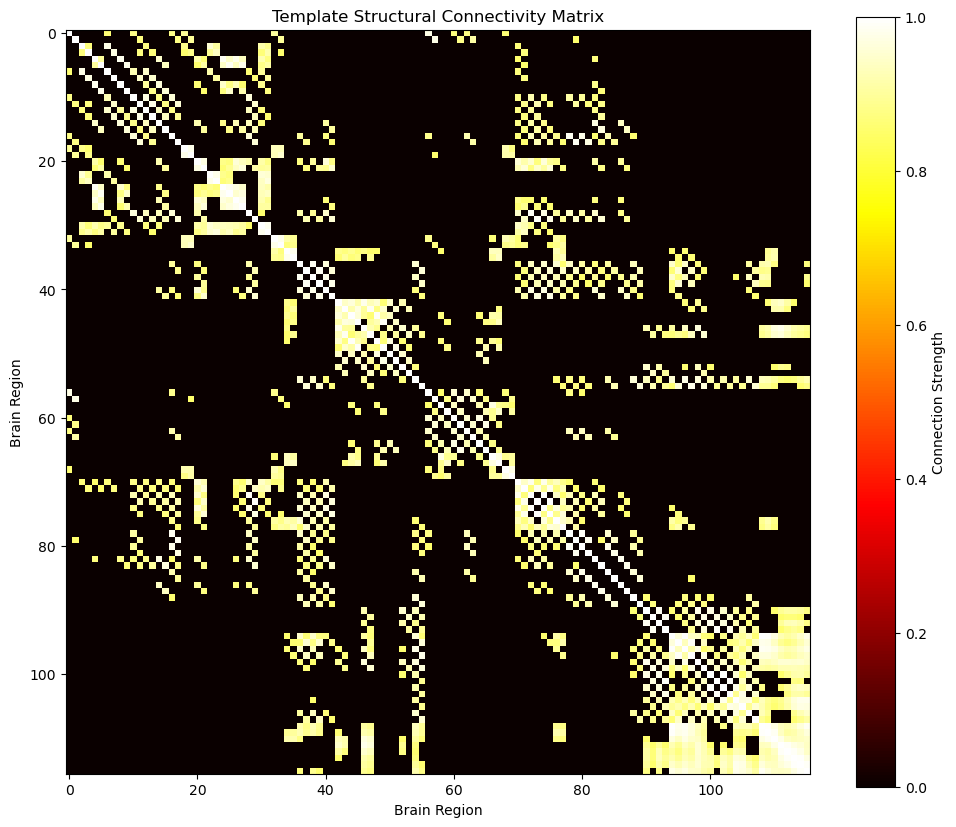


Visualizing graph structure...


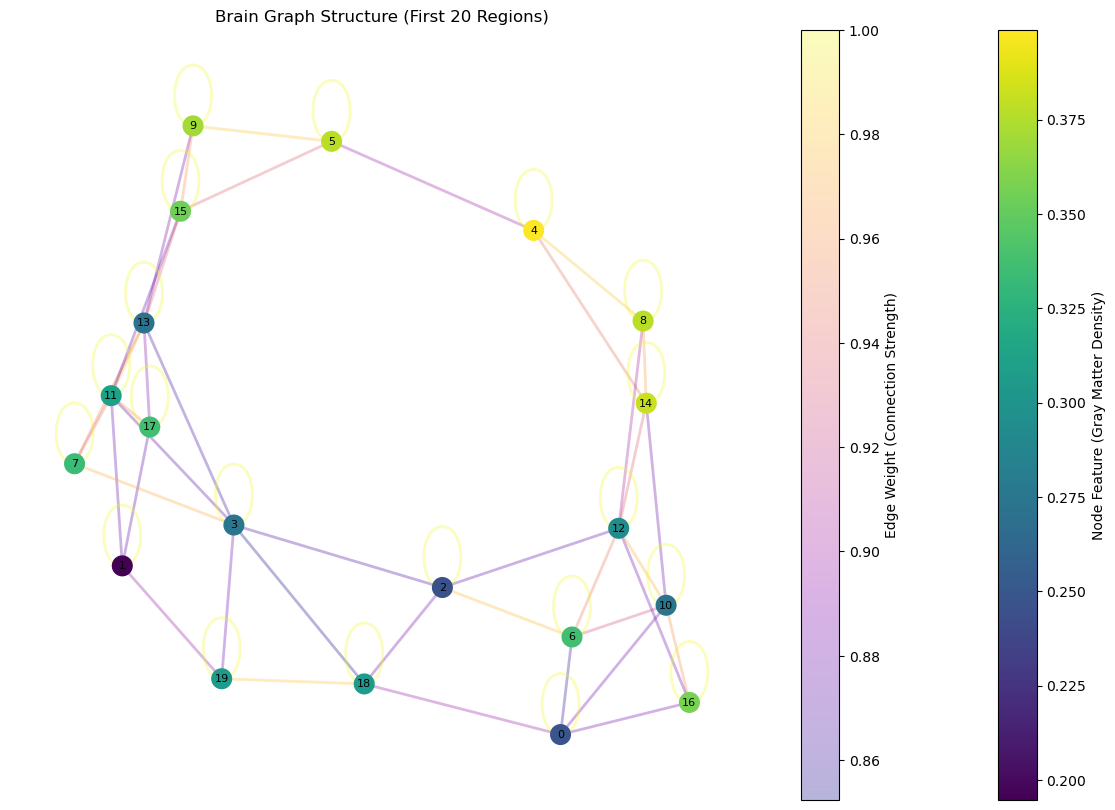


Visualizing node features distribution...


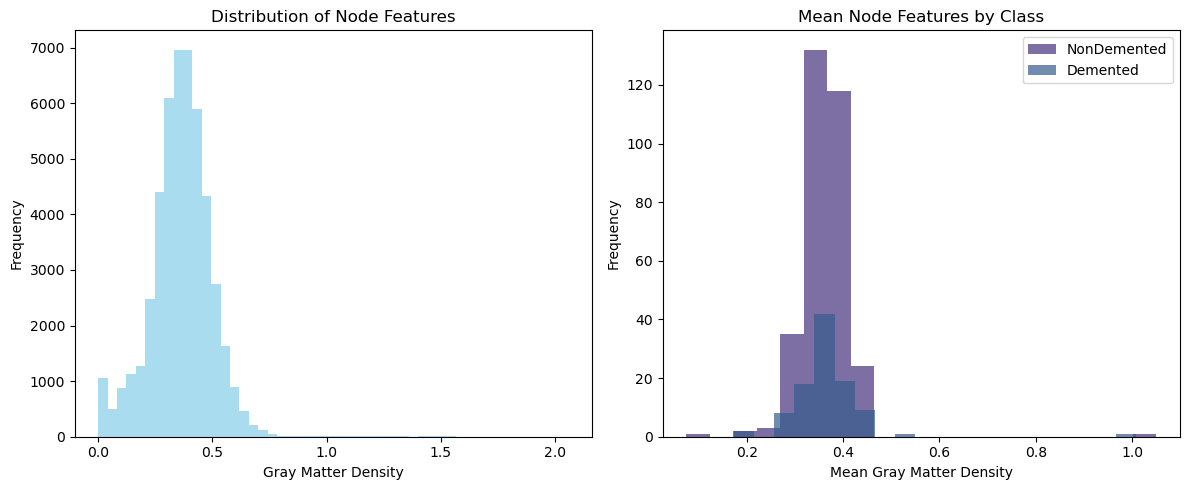


Visualizing brain regions...
[fetch_atlas_aal] Dataset found in C:\Users\rakes\nilearn_data\aal_SPM12


C:\Users\rakes\AppData\Local\Temp\ipykernel_22708\4170968461.py:141: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal_atlas = datasets.fetch_atlas_aal()


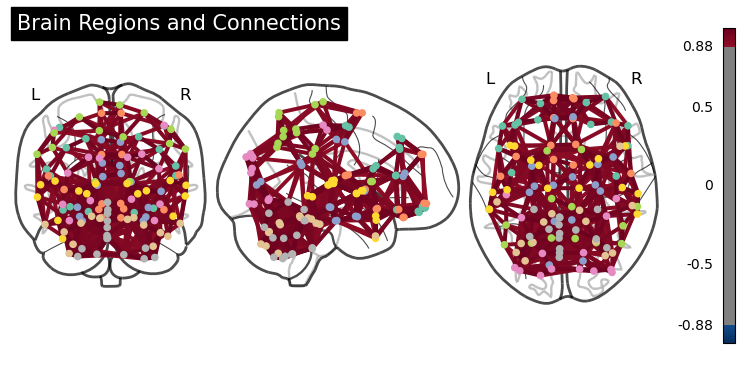

3D interactive visualization saved as HTML

Analyzing graph properties...


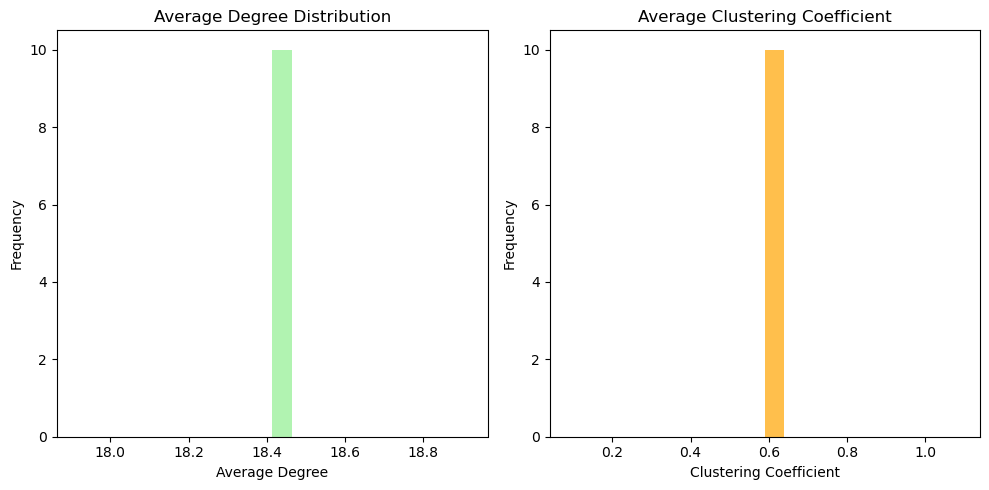


GRAPH VISUALIZATION COMPLETE
Visualizations saved to the results directory:
- Connectivity matrix: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results\connectivity_matrix.png
- Graph structure: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results\graph_structure.png
- Node features distribution: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results\node_features_distribution.png
- Brain regions: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results\brain_regions.png
- Graph properties: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results\graph_properties.png
- 3D interactive visualization: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\results\3d_brain_connectome.html


In [38]:
# Create a new notebook: 02b_Graph_Visualization.ipynb

# 1. Import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from torch_geometric.utils import to_networkx
from nilearn import plotting
from config.paths import *

# Set visualization style
plt.style.use('default')
sns.set_palette("viridis")

# 2. Load the graph dataset
graph_dataset_path = os.path.join(PROCESSED_DIR, 'oasis_graph_dataset.pt')
graph_list = torch.load(graph_dataset_path)

print(f"Loaded {len(graph_list)} graphs")
print(f"Sample graph: {graph_list[0]}")

# 3. Load the dataset info
dataset_info_path = os.path.join(PROCESSED_DIR, 'dataset_info.json')
with open(dataset_info_path, 'r') as f:
    dataset_info = json.load(f)

print("Dataset info:")
for key, value in dataset_info.items():
    print(f"{key}: {value}")

# 4. Visualize the template connectivity matrix
print("\nVisualizing template connectivity matrix...")

# Get the adjacency matrix from the template
adjacency_matrix = np.zeros((dataset_info['num_nodes'], dataset_info['num_nodes']))
adjacency_matrix[graph_list[0].edge_index[0], graph_list[0].edge_index[1]] = graph_list[0].edge_attr.squeeze().numpy()

plt.figure(figsize=(12, 10))
plt.imshow(adjacency_matrix, cmap='hot', interpolation='nearest')
plt.title('Template Structural Connectivity Matrix')
plt.colorbar(label='Connection Strength')
plt.xlabel('Brain Region')
plt.ylabel('Brain Region')
plt.savefig(os.path.join(RESULTS_DIR, 'connectivity_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# 5. Visualize a subset of the graph using NetworkX
print("\nVisualizing graph structure...")

# Convert a sample graph to NetworkX format
sample_graph = graph_list[0]

# Create a smaller subgraph for visualization (first 20 nodes)
subgraph_nodes = 20
subgraph_edge_mask = (sample_graph.edge_index[0] < subgraph_nodes) & (sample_graph.edge_index[1] < subgraph_nodes)
subgraph_edge_index = sample_graph.edge_index[:, subgraph_edge_mask]
subgraph_edge_attr = sample_graph.edge_attr[subgraph_edge_mask]

# Create a NetworkX graph
G = nx.Graph()

# Add nodes
for i in range(subgraph_nodes):
    G.add_node(i, feature=sample_graph.x[i].item())

# Add edges with weights
for i in range(subgraph_edge_index.shape[1]):
    src = subgraph_edge_index[0, i].item()
    dst = subgraph_edge_index[1, i].item()
    weight = subgraph_edge_attr[i].item()
    G.add_edge(src, dst, weight=weight)

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
node_colors = [G.nodes[n]['feature'] for n in G.nodes()]
edge_weights = [G.edges[e]['weight'] for e in G.edges()]

# Draw nodes
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                              node_size=200, cmap=plt.cm.viridis)
# Draw edges
edges = nx.draw_networkx_edges(G, pos, width=2, alpha=0.3, 
                              edge_color=edge_weights, edge_cmap=plt.cm.plasma)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8)

# Add colorbars
plt.colorbar(nodes, label='Node Feature (Gray Matter Density)')
plt.colorbar(edges, label='Edge Weight (Connection Strength)')

plt.title(f'Brain Graph Structure (First {subgraph_nodes} Regions)')
plt.axis('off')
plt.savefig(os.path.join(RESULTS_DIR, 'graph_structure.png'), dpi=300, bbox_inches='tight')
plt.show()

# 6. Visualize node features distribution
print("\nVisualizing node features distribution...")

# Get all node features
all_node_features = []
for graph in graph_list:
    all_node_features.extend(graph.x.numpy().flatten())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_node_features, bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Node Features')
plt.xlabel('Gray Matter Density')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
# Plot mean node features for each graph
mean_features = [graph.x.mean().item() for graph in graph_list]
labels = [graph.y.item() for graph in graph_list]

# Separate by class
mean_features_0 = [mean_features[i] for i in range(len(mean_features)) if labels[i] == 0]
mean_features_1 = [mean_features[i] for i in range(len(mean_features)) if labels[i] == 1]

plt.hist(mean_features_0, alpha=0.7, label='NonDemented', bins=20)
plt.hist(mean_features_1, alpha=0.7, label='Demented', bins=20)
plt.title('Mean Node Features by Class')
plt.xlabel('Mean Gray Matter Density')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'node_features_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# 7. Visualize the brain regions using Nilearn
print("\nVisualizing brain regions...")

# Load the AAL atlas
from nilearn import datasets
aal_atlas = datasets.fetch_atlas_aal()
atlas_filename = aal_atlas.maps

# Get coordinates for the regions
from nilearn.plotting import find_parcellation_cut_coords
coords = find_parcellation_cut_coords(atlas_filename)

# Plot the brain regions
plotting.plot_connectome(adjacency_matrix, coords, edge_threshold='90%',
                        title='Brain Regions and Connections', 
                        node_size=20, colorbar=True)
plt.savefig(os.path.join(RESULTS_DIR, 'brain_regions.png'), dpi=300, bbox_inches='tight')
plt.show()

# 8. Create a 3D interactive visualization (if in Jupyter)
try:
    from nilearn import plotting
    html_view = plotting.view_connectome(adjacency_matrix, coords, edge_threshold='90%')
    html_view.save_as_html(os.path.join(RESULTS_DIR, '3d_brain_connectome.html'))
    print("3D interactive visualization saved as HTML")
except Exception as e:
    print(f"Could not create 3D visualization: {e}")

# 9. Analyze graph properties
print("\nAnalyzing graph properties...")

# Calculate some graph metrics for each graph
avg_degrees = []
avg_clustering = []

for graph in graph_list[:10]:  # Just do for first 10 to save time
    # Convert to NetworkX
    G = nx.Graph()
    for i in range(graph.num_nodes):
        G.add_node(i)
    
    for i in range(graph.edge_index.shape[1]):
        src = graph.edge_index[0, i].item()
        dst = graph.edge_index[1, i].item()
        G.add_edge(src, dst)
    
    # Calculate metrics
    avg_degrees.append(np.mean(list(dict(G.degree()).values())))
    avg_clustering.append(nx.average_clustering(G))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(avg_degrees, bins=20, alpha=0.7, color='lightgreen')
plt.title('Average Degree Distribution')
plt.xlabel('Average Degree')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(avg_clustering, bins=20, alpha=0.7, color='orange')
plt.title('Average Clustering Coefficient')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'graph_properties.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("GRAPH VISUALIZATION COMPLETE")
print("="*60)
print("Visualizations saved to the results directory:")
print(f"- Connectivity matrix: {os.path.join(RESULTS_DIR, 'connectivity_matrix.png')}")
print(f"- Graph structure: {os.path.join(RESULTS_DIR, 'graph_structure.png')}")
print(f"- Node features distribution: {os.path.join(RESULTS_DIR, 'node_features_distribution.png')}")
print(f"- Brain regions: {os.path.join(RESULTS_DIR, 'brain_regions.png')}")
print(f"- Graph properties: {os.path.join(RESULTS_DIR, 'graph_properties.png')}")
if os.path.exists(os.path.join(RESULTS_DIR, '3d_brain_connectome.html')):
    print(f"- 3D interactive visualization: {os.path.join(RESULTS_DIR, '3d_brain_connectome.html')}")